In [5]:
import warnings
import torch
import numpy as np
import pandas as pd

from skrub import TableVectorizer
from sklearn.datasets import fetch_openml
from mapie.utils import train_conformalize_test_split

from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [13]:
df = fetch_openml(data_id=372, as_frame='auto') # 42178, 188
X = df.data

from scipy.sparse import csr_matrix
if isinstance(X, csr_matrix):
    print("Converting sparse matrix to dense DataFrame " + str(X.shape))
    X = pd.DataFrame(X.toarray(), columns=df.feature_names)

cols_to_drop = X.columns[X.nunique() <= 1]
if not cols_to_drop.empty:
    X = X.drop(columns=cols_to_drop)

float64_cols = X.select_dtypes(np.float64).columns
X[float64_cols] = X[float64_cols].astype(np.float32)

if df.target.dtype.name == 'category':
    y = df.target.cat.codes.to_numpy()
else:
    y = pd.factorize(df.target)[0]

X_train, X_conformalize, X_test, y_train, y_conformalize, y_test = train_conformalize_test_split(
    X, y, train_size=0.4, conformalize_size=0.4, test_size=0.2,# random_state=382114703,
)

vectorizer = TableVectorizer(drop_if_constant=True)
X_train = vectorizer.fit_transform(X_train)
X_conformalize = vectorizer.transform(X_conformalize)
X_test = vectorizer.transform(X_test)
# np.unique(y, return_counts=True)

In [14]:
np.unique(y), np.unique(y_train), np.unique(y_conformalize), np.unique(y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int8),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int8),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int8),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int8))

In [46]:
# get the unique values in each column of X_train
X_train = X_train.to_numpy()
unique_values = [np.unique(X_train[:, col]) for col in range(X_train.shape[1])]

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

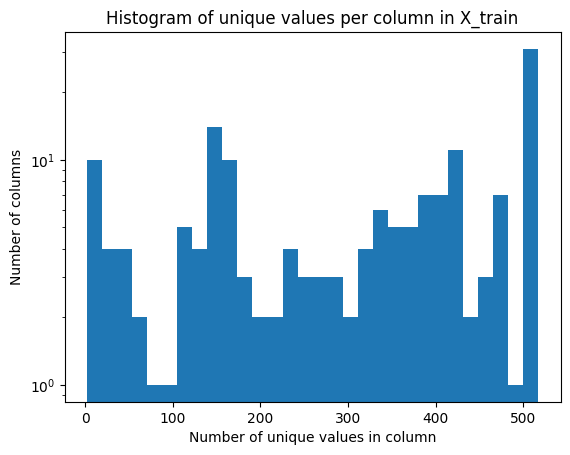

In [47]:
#histogram of the lengths of unique values
lengths = [len(u) for u in unique_values]
import matplotlib.pyplot as plt
plt.hist(lengths, bins=30)
plt.yscale('log')
plt.xlabel('Number of unique values in column')
plt.ylabel('Number of columns')
plt.title('Histogram of unique values per column in X_train')
plt.show()

In [49]:
idx = lengths.index(1)
unique_values[idx]

ValueError: 1 is not in list

In [1]:
import os
import numpy as np
import pandas as pd

# results = pd.concat([pd.read_csv(f'results/{file}') for file in os.listdir('results') if file.endswith('.csv') and file != 'raw.csv'], ignore_index=True)
results = pd.read_csv('results/raw.csv')

res = results[["dataset_id", "seed", "model", "accuracy", "f1_score", "cr", "mwc", "sscs"]].sort_values(by=["dataset_id", "seed", "model"]).reset_index(drop=True)
metric_cols = ["accuracy", "f1_score", "cr", "mwc", "sscs"]

res[metric_cols] = res[metric_cols].apply(pd.to_numeric, errors="coerce")
summary = res.groupby(["dataset_id", "model"])[metric_cols].agg(['mean', 'std']).reset_index()

summary.columns = ["_".join([x for x in col if x]).strip() if isinstance(col, tuple) else col for col in summary.columns]
summary

,dataset_id,model,accuracy_mean,accuracy_std,f1_score_mean,f1_score_std,cr_mean,cr_std,mwc_mean,mwc_std,sscs_mean,sscs_std
0,3,CatBoost,0.991797,0.003434,0.991798,0.003433,0.902891,0.016484,0.904453,0.016216,0.000000,0.000000
1,3,LightGBM,0.992969,0.003494,0.992969,0.003494,0.899062,0.018698,0.900469,0.018572,0.000000,0.000000
2,3,LogisticRegression,0.957031,0.008135,0.957024,0.008140,0.899375,0.015808,0.913672,0.016682,0.000000,0.000000
3,3,TabICL,0.993984,0.003257,0.993984,0.003257,0.901719,0.013507,0.903047,0.013205,0.000000,0.000000
4,3,TabM,0.993359,0.003120,0.993359,0.003121,0.900938,0.016763,0.902266,0.016547,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
681,45648,LogisticRegression,0.874091,0.017296,0.865761,0.018681,0.900455,0.026984,1.062424,0.038612,0.894557,0.025066
682,45648,TabICL,0.883485,0.015898,0.866966,0.019943,0.905303,0.023055,1.055303,0.032576,0.900304,0.021533
683,45648,TabM,0.883788,0.015892,0.867345,0.020524,0.903485,0.028072,1.043182,0.035623,0.813672,0.279122
684,45648,TabPFN,0.881364,0.018242,0.866103,0.020828,0.906212,0.023931,1.060758,0.035002,0.900648,0.022681


In [2]:
len(np.unique(results["dataset_id"]))

98

In [3]:
(results.shape[0]) // 140

98

In [83]:
results[results["dataset_id"] == 1487].shape, results[results["dataset_id"] == 45075].shape

((154, 13), (140, 13))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


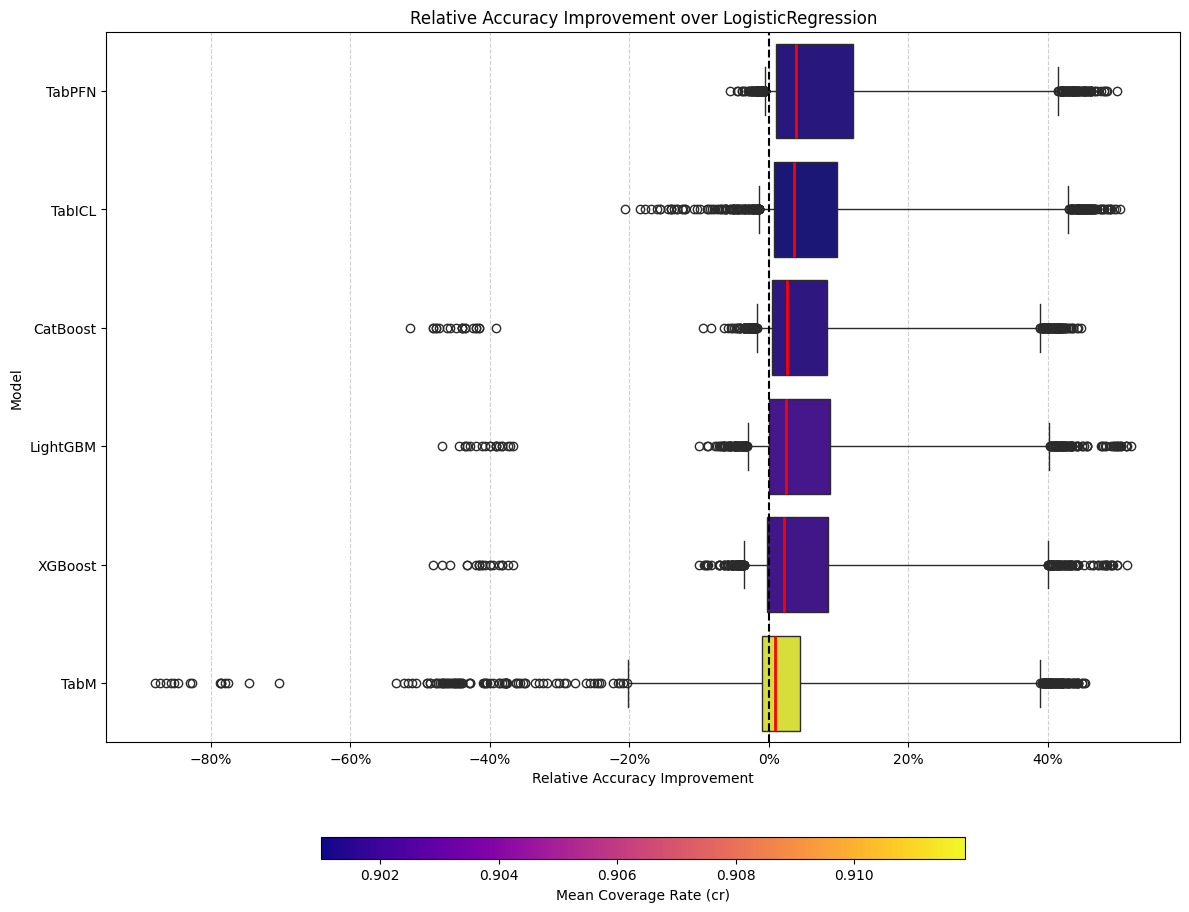

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

# Isolate the baseline model results (assuming the model is named 'LogisticRegression' in your data)
baseline_model_name = "LogisticRegression"
metric = "f1_score"
metric = "accuracy"
baseline_df = res[res["model"] == baseline_model_name][["dataset_id", "seed", metric]].rename(
    columns={metric: f"baseline_{metric}"}
)

# Merge baseline metric back into the main results
improvement_df = pd.merge(res, baseline_df, on=["dataset_id", "seed"])

# Calculate the relative metric improvement
improvement_df["improvement"] = (improvement_df[metric] - improvement_df[f"baseline_{metric}"])

# Filter out the baseline model itself from the plot
plot_df = improvement_df[improvement_df["model"] != baseline_model_name]

# Calculate the median improvement for each model to determine the order
median_improvement = plot_df.groupby("model")["improvement"].median().sort_values(ascending=False)
model_order = median_improvement.index

# --- Create Custom Palette based on mean 'cr' ---
# Calculate the mean 'cr' for each model
mean_cr = plot_df.groupby("model")["cr"].mean().loc[model_order]

# Create a normalizer to map 'cr' values to the [0, 1] range
norm = mcolors.Normalize(vmin=mean_cr.min(), vmax=mean_cr.max())

# Get a colormap (plasma is similar to the example)
cmap = plt.get_cmap('plasma')

# Create a dictionary mapping each model to a color
custom_palette = {model: cmap(norm(cr_val)) for model, cr_val in mean_cr.items()}
# --- End Custom Palette ---


# Create the horizontal box plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    ax=ax,
    data=plot_df,
    y="model",
    x="improvement",
    orient="h",
    order=model_order,  # Order models by median improvement
    palette=custom_palette, # Use the custom palette
    whis=[5, 95], # Adjust whiskers to show 5th and 95th percentiles
    showfliers=True, # Show outliers
    hue="model", # Add hue for better color distinction (optional)
    legend=False,
    medianprops={'color': 'red', 'linewidth': 2}, 
)

# Add a vertical line at 0 for reference
ax.axvline(0, color="black", linestyle="--", zorder=10)

# --- Add Colorbar ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.1, shrink=0.6, aspect=30)
cbar.set_label('Mean Coverage Rate (cr)')
# --- End Colorbar ---

# Formatting
ax.set_title(f"Relative Accuracy Improvement over {baseline_model_name}")
ax.set_xlabel("Relative Accuracy Improvement")
ax.set_ylabel("Model")
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
# plt.savefig(f"figures/improvement_over_{baseline_model_name}_{metric}.png", dpi=300)
# plt.savefig(f"figures/improvement_over_{baseline_model_name}_{metric}.eps", dpi=300)
plt.show()